In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pwd

'/content'

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('./drive/MyDrive/netflix_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

from collections import defaultdict


./drive/MyDrive/netflix_data/README
./drive/MyDrive/netflix_data/combined_data_1.txt
./drive/MyDrive/netflix_data/combined_data_2.txt
./drive/MyDrive/netflix_data/combined_data_3.txt
./drive/MyDrive/netflix_data/combined_data_4.txt
./drive/MyDrive/netflix_data/probe.txt
./drive/MyDrive/netflix_data/qualifying.txt
./drive/MyDrive/netflix_data/netflix_inspect.txt
./drive/MyDrive/netflix_data/movie_titles.csv


In [ ]:
ls ./drive/MyDrive/

 Classroom/                                        intro_to_python.ipynb
'Colab Notebooks'/                                 nba_data.csv
'Copy of AA PLANNING MAP PUBLIC_JAN 2025.gsheet'   netflix_data@
 Gmail


In [6]:
import os
import pandas as pd

# Time the entire data load + processing block
# %%time

files = ['./drive/MyDrive/netflix_data/combined_data_1.txt',
         './drive/MyDrive/netflix_data/combined_data_2.txt',
#         './drive/MyDrive/netflix_data/combined_data_3.txt',
#         './drive/MyDrive/netflix_data/combined_data_4.txt'
        ]

# Combine data only if it hasn't been processed yet
if not os.path.isfile('data.csv'):
    with open('data.csv', mode='w') as data:
        for file in files:
            print(f"Opening file: {file}")
            with open(file, 'r') as f:
                movie_id = None
                for line in f:
                    line = line.strip()
                    if line.endswith(':'):
                        movie_id = line.replace(':', '')
                    elif movie_id and line:  # Ensure movie_id is set
                        data.write(f"{movie_id},{line}\n")

# Load into pandas DataFrame
df = pd.read_csv('data.csv', names=['movie_id', 'user_id', 'rating', 'date'])
print(df.nunique())
df.head()


movie_id      9210
user_id     478018
rating           5
date          2182
dtype: int64


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [7]:
lite_rating_df = pd.DataFrame()

group = df.groupby('user_id')['rating'].count()
top_users = group.sort_values(ascending=False)[:10000]

group = df.groupby('movie_id')['rating'].count()
top_movies = group.sort_values(ascending=False)[:2000]

lite_rating_df = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
lite_rating_df = lite_rating_df.join(top_movies, rsuffix='_r', how='inner', on='movie_id')

# Re-name the users and movies for uniform name from 0..2000 and 10000
user_enc = LabelEncoder()
lite_rating_df['user'] = user_enc.fit_transform(lite_rating_df['user_id'].values)
movie_enc = LabelEncoder()
lite_rating_df['movie'] = movie_enc.fit_transform(lite_rating_df['movie_id'].values)

n_movies = lite_rating_df['movie'].nunique()
n_users = lite_rating_df['user'].nunique()

# print(n_movies, n_users)
lite_rating_df

,movie_id,user_id,rating,date,rating_r,rating_r,user,movie
5111,8,1744889,1,2005-08-25,1423,14910,6572,0
5149,8,1488844,4,2005-05-12,1127,14910,5613,0
5167,8,306466,4,2005-07-01,1190,14910,1081,0
5176,8,1987434,4,2005-10-04,575,14910,7467,0
5181,8,573364,1,2005-11-22,653,14910,2106,0
...,...,...,...,...,...,...,...,...
51029387,9208,1561134,4,2005-01-19,1499,18969,5876,1999
51029391,9208,2507981,4,2005-02-03,571,18969,9447,1999
51029403,9208,2195240,3,2005-06-14,631,18969,8244,1999
51029407,9208,1055714,5,2005-06-20,750,18969,3935,1999


In [8]:
movie_titles = pd.read_csv('movie_titles.csv', header=None, index_col=0)
title_dict = dict(zip(movie_titles.index, movie_titles[2]))

In [9]:
len(top_movies), len(title_dict)

(2000, 17770)

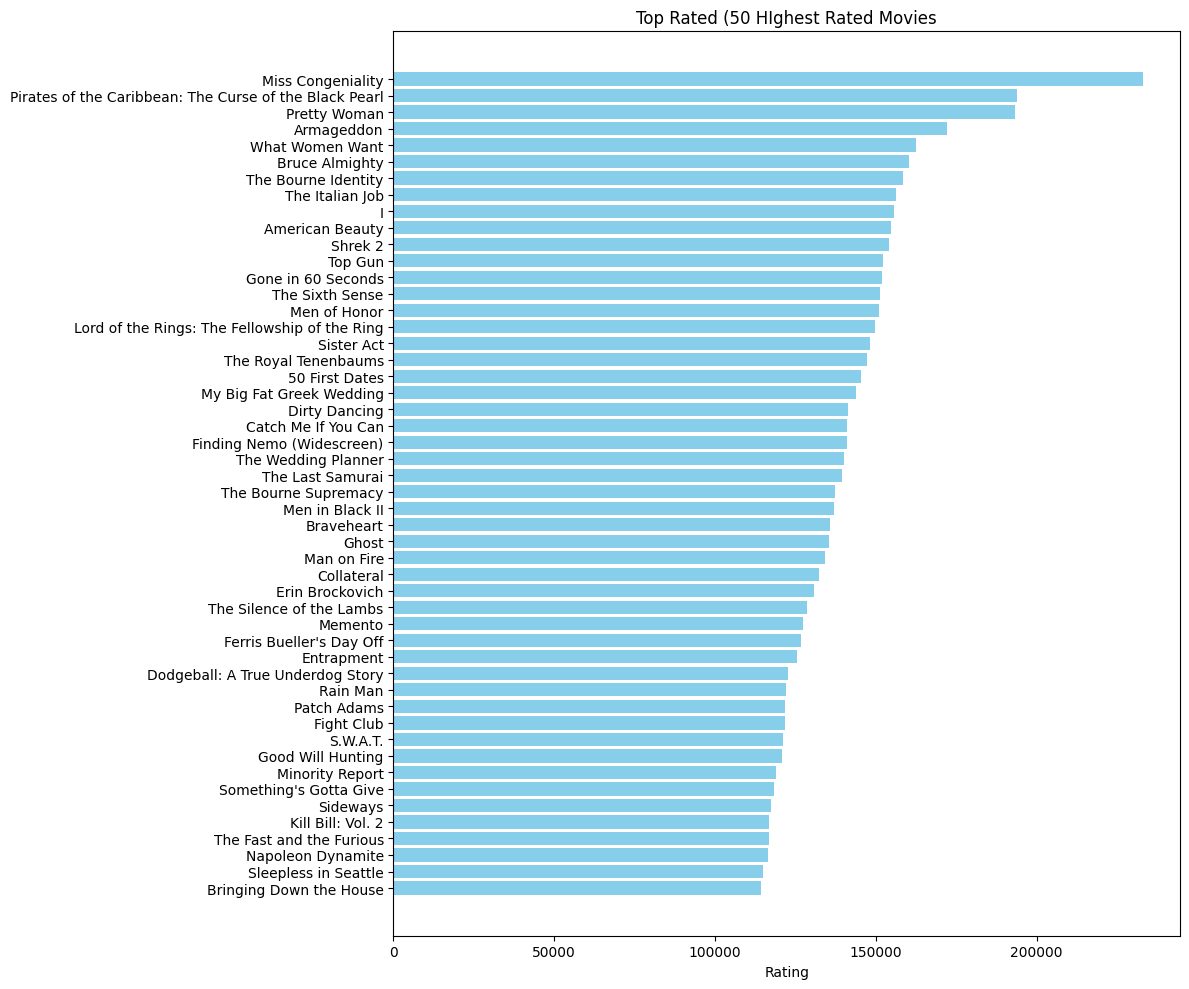

In [10]:
import matplotlib.pyplot as plt

# Convert dict to sorted list of tuples
plot_data = [(title_dict[i], j) for i, j in top_movies.items()][:50]
plot_data.sort(key=lambda x: x[1], reverse=True)  # Optional: sort by score

# Separate titles and values
titles = [item[0] for item in plot_data]
values = [item[1] for item in plot_data]

# Plot
plt.figure(figsize=(12, 10))
plt.barh(titles, values, color='skyblue')
plt.xlabel('Rating')
plt.title('Top Rated (50 HIghest Rated Movies')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()


In [11]:
X = lite_rating_df[['user', 'movie']].values
y = lite_rating_df['rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 200 # was 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [12]:
len(X_training)

5870451

In [13]:
X_training[0]

array([ 260, 1059])

In [14]:
y_training[0]

np.int64(5)

In [ ]:
# # Build user and movie embedding matrix
# user = Input(shape=(1,))
# u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
#               embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
# u = Reshape((e_dimension,))(u)
# movie = Input(shape=(1,))
# m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
#               embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
# m = Reshape((e_dimension,))(m)

# x = Dot(axes=1)([u, m])
# ## new : concat user, id along with dot
# x = Concatenate()([u, m,x])
# x = Dropout(0.2)(x)

# # Build last deep learning layers
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
# # x = Dense(128, activation='relu')(x)
# # x = Dropout(0.2)(x)
# x = Dense(1)(x)

# model = Model(inputs=[user, movie], outputs=x)
# model.compile(loss='mean_squared_error',
#               optimizer=Adam(learning_rate=0.003),  ## 0.001
#               metrics=[tf.keras.metrics.RootMeanSquaredError()]
#               )

# # Set up for early stop if the validation loss stop improving for more than 1 epoch
# callbacks_list = [
#     keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=1,
#     ),
#     keras.callbacks.ModelCheckpoint(
#         filepath='Model_1.keras',  # must end with .keras
#         monitor='val_loss',
#         save_best_only=True,
#     )
# ]

# # Print model info summary
# model.summary()

# history = model.fit(x=X_train_array, y=y_train, batch_size=64,
#                     epochs=10, # 20
#                     verbose=1,
#                     callbacks=callbacks_list,
#                     validation_data=(X_val_array, y_val)
#                     )

# # Save the model (we should make a good habit of always saving our models after training)
# model.save("Model_1")


In [74]:
model = keras.models.load_model('Model_1.keras')


In [75]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 200)    │  2,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 200)    │    400,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 200)       │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 200)       │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ reshape_2[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 401)       │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0],  │
│                     │                   │            │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 401)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    102,912 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,509,509 (28.65 MB)

 Trainable params: 2,503,169 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,006,340 (19.10 MB)

In [23]:
netflix_titles = pd.read_csv('netflix_titles.csv')

In [24]:
netflix_titles

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [25]:
movies = list(movie_titles[2].values)

title_dict = dict(zip(movie_titles.index, movie_titles[2]))

In [27]:
title_dict

{1: 'Dinosaur Planet',
 2: 'Isle of Man TT 2004 Review',
 3: 'Character',
 4: "Paula Abdul's Get Up & Dance",
 5: 'The Rise and Fall of ECW',
 6: 'Sick',
 7: '8 Man',
 8: 'What the #$*! Do We Know!?',
 9: "Class of Nuke 'Em High 2",
 10: 'Fighter',
 11: 'Full Frame: Documentary Shorts',
 12: 'My Favorite Brunette',
 13: 'Lord of the Rings: The Return of the King: Extended Edition: Bonus Material',
 14: 'Nature: Antarctica',
 15: 'Neil Diamond: Greatest Hits Live',
 16: 'Screamers',
 17: '7 Seconds',
 18: 'Immortal Beloved',
 19: "By Dawn's Early Light",
 20: 'Seeta Aur Geeta',
 21: 'Strange Relations',
 22: 'Chump Change',
 23: "Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo",
 24: 'My Bloody Valentine',
 25: 'Inspector Morse 31: Death Is Now My Neighbour',
 26: 'Never Die Alone',
 27: "Sesame Street: Elmo's World: The Street We Live On",
 28: 'Lilo and Stitch',
 29: 'Boycott',
 30: "Something's Gotta Give",
 31: 'Classic Albums: Meat Loaf: Bat Out of Hell',
 32: 

In [28]:
netflix_in_both = netflix_titles[netflix_titles['title'].isin(movies)]
np.unique(netflix_in_both['type'])

array(['Movie', 'TV Show'], dtype=object)

In [29]:
netflix_in_both

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
27,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103 min,Comedies,Mourning the loss of their beloved junior high...
41,s42,Movie,Jaws,Steven Spielberg,"Roy Scheider, Robert Shaw, Richard Dreyfuss, L...",United States,"September 16, 2021",1975,PG,124 min,"Action & Adventure, Classic Movies, Dramas",When an insatiable great white shark terrorize...
42,s43,Movie,Jaws 2,Jeannot Szwarc,"Roy Scheider, Lorraine Gary, Murray Hamilton, ...",United States,"September 16, 2021",1978,PG,116 min,"Dramas, Horror Movies, Thrillers",Four years after the last deadly shark attacks...
...,...,...,...,...,...,...,...,...,...,...,...,...
8735,s8736,Movie,Who's That Knocking at My Door?,Martin Scorsese,"Zina Bethune, Harvey Keitel, Anne Collette, Le...",United States,"July 1, 2019",1967,R,90 min,"Classic Movies, Dramas, Independent Movies",A woman's revelation that she was once raped s...
8742,s8743,Movie,Wild Wild West,Barry Sonnenfeld,"Will Smith, Kevin Kline, Kenneth Branagh, Salm...",United States,"January 1, 2020",1999,PG-13,106 min,"Action & Adventure, Comedies, Sci-Fi & Fantasy","Armed with an ingenious arsenal, two top-notch..."
8745,s8746,Movie,Willy Wonka & the Chocolate Factory,Mel Stuart,"Gene Wilder, Jack Albertson, Peter Ostrum, Roy...","United States, East Germany, West Germany","January 1, 2020",1971,G,100 min,"Children & Family Movies, Classic Movies, Come...",Zany Willy Wonka causes a stir when he announc...
8767,s8768,Movie,XXX: State of the Union,Lee Tamahori,"Ice Cube, Samuel L. Jackson, Willem Dafoe, Sco...",United States,"January 1, 2019",2005,PG-13,101 min,Action & Adventure,"In this action-packed follow-up to XXX, U.S. i..."


In [32]:
len(np.unique(netflix_in_both['listed_in']))

212

In [65]:
movie_genres = defaultdict(list)

for index, row in netflix_in_both.iterrows():
  movie_index = int(movie_titles[movie_titles[2] == row['title']].index[0])
  if 'Comedies' in row['listed_in']:
    movie_genres['comedy'].append([movie_index, row['title']])
    #print(row['title'], row['listed_in'])

  if 'Horror' in row['listed_in'] or 'Thriller' in row['listed_in']:
     movie_genres['horror'].append([movie_index, row['title']])

  if 'Drama' in row['listed_in'] or 'Romance' in row['listed_in']:
     movie_genres['drama'].append([movie_index, row['title']])


  if 'Childrens' in row['listed_in'] or 'Kids' in row['listed_in']:
     movie_genres['kids'].append([movie_index, row['title']])

  if 'Action' in row['listed_in']  or 'Adventure' in row['listed_in']:
     movie_genres['action'].append([movie_index, row['title']])

In [66]:
movie_genres.keys()

dict_keys(['horror', 'drama', 'comedy', 'action', 'kids'])

In [67]:
for key, value in movie_genres.items():
  print (key)
  print (len(value))

horror
112
drama
321
comedy
230
action
177
kids
14


In [69]:
import tqdm

In [78]:
user_id = 808
movie_id = 888

input_pair = [np.array([user_id]), np.array([movie_id])]
predicted_rating = model.predict(input_pair)
print(predicted_rating)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[2.9864025]]


In [79]:
from collections import defaultdict
import numpy as np

# Create user and movie encoders
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

# Fit encoders on all data
user_encoder.fit(lite_rating_df['user'])
movie_encoder.fit(lite_rating_df['movie'])

# Encode the user_id once
encoded_user_id = user_encoder.transform([user_id])[0]

# Initialize score dictionary
movie_scores = defaultdict(list)

for key, value in movie_genres.items():
    for i in value:
        try:
            # Encode movie ID
            encoded_movie_id = movie_encoder.transform([i[0]])[0]

            # Format input and predict
            input_pair = [np.array([encoded_user_id]), np.array([encoded_movie_id])]
            predicted_rating = model.predict(input_pair, verbose=0)[0][0]

            # Store the result
            movie_scores[key].append(predicted_rating)

        except ValueError:
            # Skip if movie ID was not seen during training
            continue



In [83]:
for i, j in movie_scores.items():
  print (i)
  print (np.median(j))

horror
3.728531
drama
3.6463351
comedy
3.6882102
action
3.5254574


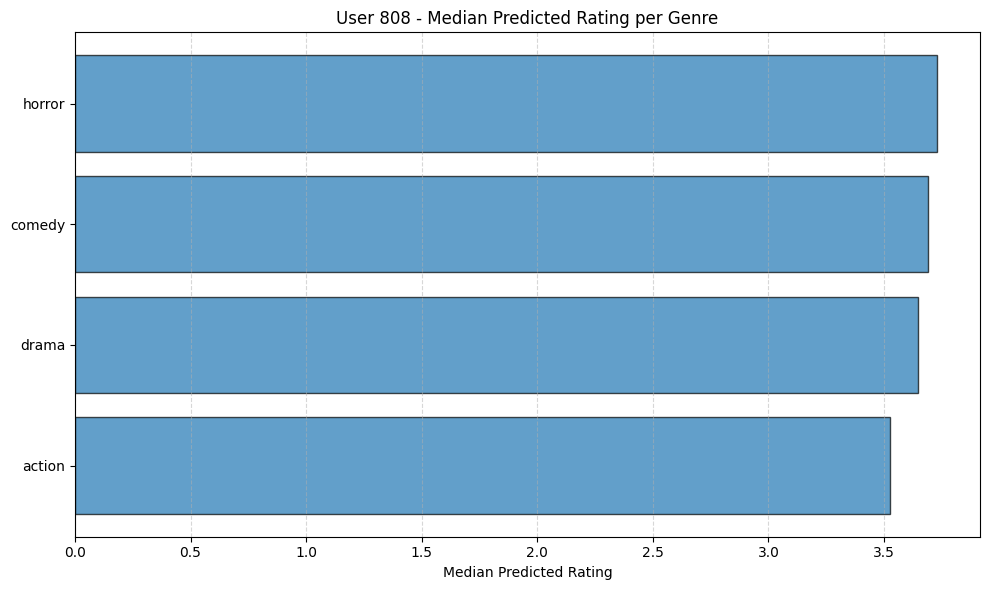

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Extract genres and median scores
genres = []
median_scores = []

for genre, scores in movie_scores.items():
    if scores:  # avoid empty lists
        genres.append(genre)
        median_scores.append(np.median(scores))

# Sort by median score (optional)
sorted_indices = np.argsort(median_scores)[::-1]  # descending
genres = [genres[i] for i in sorted_indices]
median_scores = [median_scores[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(genres, median_scores, edgecolor='black', alpha=0.7)
plt.xlabel("Median Predicted Rating")
plt.title("User 808 - Median Predicted Rating per Genre")
plt.gca().invert_yaxis()  # Highest scores at top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()